In [4]:
from dateutil.relativedelta import relativedelta
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import numpy as np
import sklearn.metrics as metrics
import scipy.stats
import matplotlib.cm as cm
import random
import statistics
import math

In [14]:
#Read URL data
with open('NameURL/disaster.pkl', 'rb') as f:
    disaster_dict = pickle.load(f)

with open('NameURL/death.pkl', 'rb') as f:
    death_dict = pickle.load(f)

with open('NameURL/aviation.pkl', 'rb') as f:
    aviation_dict = pickle.load(f)

with open('NameURL/murder.pkl', 'rb') as f:
    murder_dict = pickle.load(f)

with open('NameURL/tero.pkl', 'rb') as f:
    tero_dict = pickle.load(f)

In [15]:
#Check the number of pages that have been dated
files_dict=[disaster_dict, death_dict, aviation_dict, murder_dict, tero_dict]

for file in files_dict:
    print(f"{len(file)}")

74
22319
107
121
403


### Get the number of views for 300 days

In [7]:
import pageviewapi
from datetime import datetime as dt
import requests
from attrdict import AttrDict
import statistics
import matplotlib.pyplot as plt
import numpy as np
import datetime

__version__   = "0.4.0"
PROJECT_URL   = "https://github.com/Commonists/pageview-api"
UA            = "Python pageview-api client v{version} <{url}>"
USER_AGENT    = {'User-Agent': UA.format(url=PROJECT_URL, version=__version__)}
API_BASE_URL  = "https://wikimedia.org/api/rest_v1/metrics"
PA_ENDPOINT   = "pageviews/per-article"
PA_ARGS       = "{project}/{access}/{agent}/{page}/{granularity}/{start}/{end}"


def per_article(project, page, start, end,access='all-access', agent='all-agents', granularity='daily'):

    args = PA_ARGS.format(project=project, page=page, start=start, end=end, access=access, agent=agent, granularity=granularity)
    return __api__(PA_ENDPOINT, args)

def __api__(end_point, args, api_url=API_BASE_URL):
    
    url = "/".join([api_url, end_point, args])
    response = requests.get(url, headers=USER_AGENT)
    
    if response.status_code == 200:
        return response.json()
    
    elif response.status_code == 404:
        pass
        #print("error404:  "+args)
    
    #elif response.status_code == 429:
        #raise ThrottlingException
    
    else:
        response.raise_for_status()

In [ ]:
analysis_lis=[disaster_dict,aviation_dict,murder_dict,tero_dict,death_dict]
file_names=["disaster","aviation","murder","tero","death"]

for name_dict,file in zip(analysis_lis,file_names):
    
    #Create an empty time series data frame (index is 0 ~ 299)
    date_list =list(range(0, 300, 1))
    df_decay=pd.DataFrame(index=date_list)

    for name in name_dict:
        page_view_lis=[]
        start_date=datetime.datetime.strptime(name_dict[name], '%Y-%m-%d')#event occurance date
        last_date=start_date+datetime.timedelta(days=299)

        response=per_article('en.wikipedia', name, start_date.strftime('%Y%m%d'), last_date.strftime('%Y%m%d'), access='all-access', agent='user', granularity='daily')

        if type(response)==dict:

            Wikipedia_start=datetime.datetime.strptime(response['items'][0]["timestamp"], '%Y%m%d00')#The first day when the number of Wikipedia pages was obtained
            diff_date=Wikipedia_start-start_date

            if diff_date.days>0:#If there is nan until the first day, enter it
                page_view_lis=[np.nan]*diff_date.days
                
            if len(page_view_lis)<7 and len(page_view_lis)+len(response['items'])==300:
                
                for i in range(len(response['items'])):
                        page_view_lis.append(response['items'][i]["views"])#Add the number of views to the list in order
                df_decay[name]=page_view_lis

    dt_now = datetime.datetime.now()
    print(f"get time({file}):{dt_now}")

    df_decay.to_csv(f"TimeSeries/{file}.csv")

## fitting

In [38]:
# Definition of function to approximate
def beki(x, A, a):
    return np.log10( A * (x**(-a)) )

def exp(x, A, a):
    return np.log10( A * np.exp(-a*x))

def biexp(x, A, a, B, b):
    return np.log10( A * np.exp(-a*x) + B * np.exp(-b*x) )

def stretch(x, a, b, c):
    return np.log10( np.exp( -(x/a)**( b*x**(-c)) ) )

def shiftbeki(x, a, b, c):
    return np.log10( a * (x**(-b)) + c )

def expbeki(x, A, a, B, b):
    return np.log10( A *np.exp(-a*x)+ B*(x**(-b)) )

In [18]:
#Preprocessing
file_names=["disaster","aviation","murder","tero","death"]

for file in file_names:
    df_decay=pd.read_csv(f"TimeSeries2/{file}.csv", index_col=0)

    for name in df_decay:
        df_peak=df_decay[name][df_decay[name].idxmax():]#Change to a curve from the peak
        df_norm=df_peak/df_peak.max()#Normalization
        
        if  df_peak.max()<1000 or df_decay[name].idxmax()>=5:
            df_decay=df_decay.drop(name, axis=1)
            
    print(f"{file}_after:{len(df_decay.columns)}")
    df_decay.to_csv(f"TimeSeries_pre/{file}_pre.csv")

disaster_after:34
aviation_after:43
murder_after:37
tero_after:123
death_after:8684


### get parameter

In [ ]:
file_names=["disaster","aviation","murder","tero","death"]

for file in file_names:
    df_decay=pd.read_csv(f"TimeSeries_pre/{file}_pre.csv", index_col=0)
    
    #Create R^2 data frame (index is function name)
    r_list =["day_to_peak","peak","beki","exp","biexp","stretch","shiftbeki","expbeki","expbeki_A","expbeki_a","expbeki_B","expbeki_b","switching_point"]
    df_r=pd.DataFrame(index=r_list)
    
    #Create AIC data frame (index is function name)
    aic_list =["beki","exp","biexp","stretch","shiftbeki","expbeki"]
    df_aic=pd.DataFrame(index=aic_list)
    
    for name in df_decay:
        
        df_fromax=df_decay[name][df_decay[name].idxmax():]#Change to a curve from the peak
        minimum = np.min(df_fromax.values[np.nonzero(df_fromax.values)])#Get the minimum value other than 0
        df=df_fromax+minimum#Curve from peak + minimum value
        df_norm=df/df.max()#Normalization
        df_norm.reset_index(drop=True, inplace=True)#Index 0 start

        #analysis target
        y_analysis=np.log10(df_norm)#Normalized → logarithmically transformed time series data
        x_analysis = np.linspace(1,len(y_analysis),len(y_analysis))#x
        
        
        # Find the approximation function
        popt_beki, _      = optimize.curve_fit(beki, x_analysis, y_analysis, bounds=((0,0),(np.inf,np.inf)) )
        popt_exp, _       = optimize.curve_fit(exp, x_analysis, y_analysis, bounds=((0,0),(np.inf,np.inf)) )
        popt_biexp, _     = optimize.curve_fit(biexp, x_analysis, y_analysis, bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))
        popt_stretch, _   = optimize.curve_fit(stretch, x_analysis, y_analysis, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        popt_shiftbeki, _ = optimize.curve_fit(shiftbeki, x_analysis, y_analysis, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        popt_expbeki, _ = optimize.curve_fit(expbeki, x_analysis, y_analysis, bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))

        
        #Find the coefficient of determination
        r_beki     = metrics.r2_score(y_analysis, beki(x_analysis, *popt_beki))
        r_exp      = metrics.r2_score(y_analysis, exp(x_analysis, *popt_exp))
        r_biexp    = metrics.r2_score(y_analysis, biexp(x_analysis, *popt_biexp))
        r_stretch  = metrics.r2_score(y_analysis, stretch(x_analysis, *popt_stretch))
        r_shiftbeki= metrics.r2_score(y_analysis, shiftbeki(x_analysis, *popt_shiftbeki))
        r_expbeki  = metrics.r2_score(y_analysis, expbeki(x_analysis, *popt_expbeki))

        
        #MemorySwitchingPoint
        diff=exp(x_analysis,popt_expbeki[0],popt_expbeki[1])-beki(x_analysis,popt_expbeki[2],popt_expbeki[3])

        index=1
        switching_point=365#Permanent index (parameter without turning point)
        for i in diff:
            if i<0:
                switching_point=index
                break
            index+=1

        df_r[name]=[df_decay[name].idxmax(),df_fromax.max(),r_beki,r_exp,r_biexp,r_stretch,r_shiftbeki,r_expbeki
                            ,popt_expbeki[0],popt_expbeki[1],popt_expbeki[2],popt_expbeki[3],switching_point]


        #AIC
        result_beki = sm.OLS(y_analysis,beki(x_analysis,popt_beki[0],popt_beki[1])).fit()
        result_exp = sm.OLS(y_analysis,exp(x_analysis,popt_exp[0],popt_exp[1])).fit()
        result_biexp = sm.OLS(y_analysis,biexp(x_analysis,popt_biexp[0],popt_biexp[1],popt_biexp[2],popt_biexp[3])).fit()
        result_stretch = sm.OLS(y_analysis,stretch(x_analysis,popt_stretch[0],popt_stretch[1],popt_stretch[2])).fit()
        result_shiftbeki = sm.OLS(y_analysis,shiftbeki(x_analysis,popt_shiftbeki[0],popt_shiftbeki[1],popt_shiftbeki[2])).fit()
        result_expbeki = sm.OLS(y_analysis,expbeki(x_analysis,popt_expbeki[0],popt_expbeki[1],popt_expbeki[2],popt_expbeki[3])).fit()

        df_aic[name]=[result_beki.aic,result_exp.aic,result_biexp.aic,result_stretch.aic,result_shiftbeki.aic,result_expbeki.aic]
        
        df_r.to_csv(f"parameter/{file}_parameter_r.csv")
        df_aic.to_csv(f"parameter/{file}_parameter_aic.csv")

In [27]:
df_disaster_r=pd.read_csv(f"parameter/disaster_log.csv",index_col=0)
df_aviation_r=pd.read_csv(f"parameter/aviation_log.csv",index_col=0)
df_murder_r=pd.read_csv(f"parameter/murder_log.csv",index_col=0)
df_tero_r=pd.read_csv(f"parameter/tero_log.csv",index_col=0)
df_death_r=pd.read_csv(f"parameter/death_log.csv",index_col=0)

df_disaster_aic=pd.read_csv(f"parameter/disaster_aic_log.csv",index_col=0)
df_aviation_aic=pd.read_csv(f"parameter/aviation_aic_log.csv",index_col=0)
df_murder_aic=pd.read_csv(f"parameter/murder_aic_log.csv",index_col=0)
df_tero_aic=pd.read_csv(f"parameter/tero_aic_log.csv",index_col=0)
df_death_aic=pd.read_csv(f"parameter/death_aic_log.csv",index_col=0)

### Parameter evaluation obtained by fitting

### R^2

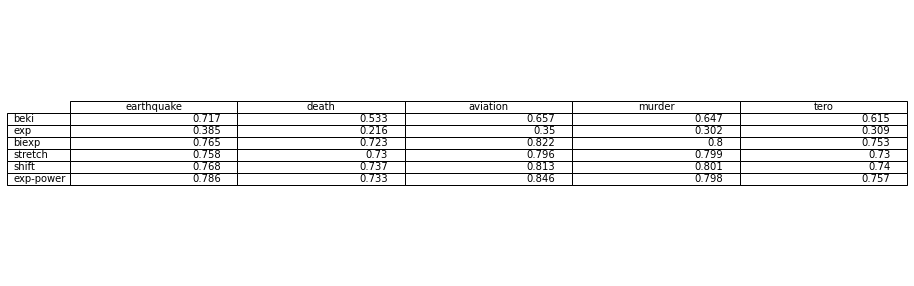

In [28]:
data = np.array([[round(df_disaster_r.loc["beki"].median(),3),round(df_death_r.loc["beki"].median(),3),round(df_aviation_r.loc["beki"].median(),3),round(df_murder_r.loc["beki"].median(),3),round(df_tero_r.loc["beki"].median(),3)],
                 [round(df_disaster_r.loc["exp"].median(),3),round(df_death_r.loc["exp"].median(),3),round(df_aviation_r.loc["exp"].median(),3),round(df_murder_r.loc["exp"].median(),3),round(df_tero_r.loc["exp"].median(),3)],
                 [round(df_disaster_r.loc["biexp"].median(),3),round(df_death_r.loc["biexp"].median(),3),round(df_aviation_r.loc["biexp"].median(),3),round(df_murder_r.loc["biexp"].median(),3),round(df_tero_r.loc["biexp"].median(),3)],
                 [round(df_disaster_r.loc["stretch"].median(),3),round(df_death_r.loc["stretch"].median(),3),round(df_aviation_r.loc["stretch"].median(),3),round(df_murder_r.loc["stretch"].median(),3),round(df_tero_r.loc["stretch"].median(),3)],
                 [round(df_disaster_r.loc["shiftbeki"].median(),3),round(df_death_r.loc["shiftbeki"].median(),3),round(df_aviation_r.loc["shiftbeki"].median(),3),round(df_murder_r.loc["shiftbeki"].median(),3),round(df_tero_r.loc["shiftbeki"].median(),3)],
                 [round(df_disaster_r.loc["expbeki"].median(),3),round(df_death_r.loc["expbeki"].median(),3),round(df_aviation_r.loc["expbeki"].median(),3),round(df_murder_r.loc["expbeki"].median(),3),round(df_tero_r.loc["expbeki"].median(),3)]])

axis1 = np.array(["earthquake","death","aviation","murder","tero"])
axis2 = ["beki","exp","biexp","stretch","shift","exp-power"]

plt.figure(figsize=(15, 5))
plt.axis('tight')
plt.axis('off')
plt.table(cellText=data, colLabels=axis1, rowLabels=axis2, loc="center",fontsize=100)

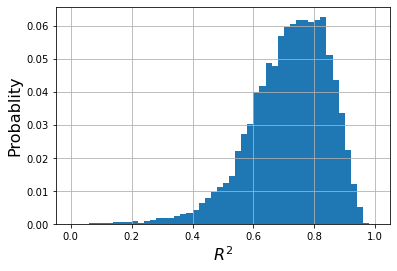

0.7326495473596305

In [29]:
#notable death
fig=plt.figure()

death_lis=df_death_r.loc["expbeki"].values.tolist()
death_weight=np.ones_like(death_lis)/len(death_lis)

plt.grid(True)

bins_lis=[]
for i in list(range(0,51,1)):
    bins_lis.append(i/50)

plt.hist(death_lis,bins=bins_lis,weights=death_weight,alpha=1)
plt.xlabel("$R^{2}$",size=16)
plt.ylabel("Probablity",size=16)
#plt.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/figure_work/hist_r.eps")
plt.show()
statistics.median(death_lis)

### AIC

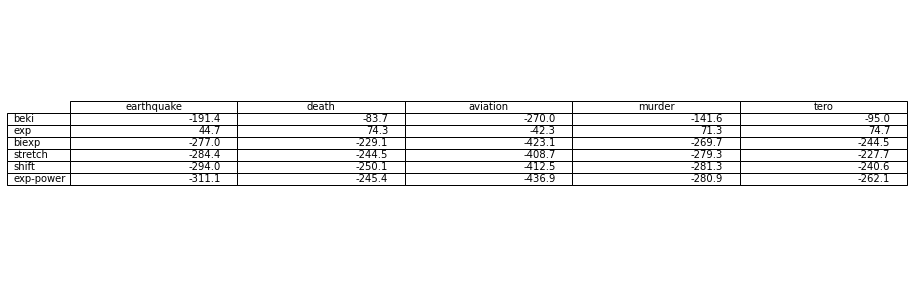

In [30]:
data = np.array([[round(df_disaster_aic.loc["beki"].median(),1),round(df_death_aic.loc["beki"].median(),1),round(df_aviation_aic.loc["beki"].median(),1),round(df_murder_aic.loc["beki"].median(),1),round(df_tero_aic.loc["beki"].median(),1)],
                 [round(df_disaster_aic.loc["exp"].median(),1),round(df_death_aic.loc["exp"].median(),1),round(df_aviation_aic.loc["exp"].median(),1),round(df_murder_aic.loc["exp"].median(),1),round(df_tero_aic.loc["exp"].median(),1)],
                 [round(df_disaster_aic.loc["biexp"].median(),1),round(df_death_aic.loc["biexp"].median(),1),round(df_aviation_aic.loc["biexp"].median(),1),round(df_murder_aic.loc["biexp"].median(),1),round(df_tero_aic.loc["biexp"].median(),1)],
                 [round(df_disaster_aic.loc["stretch"].median(),1),round(df_death_aic.loc["stretch"].median(),1),round(df_aviation_aic.loc["stretch"].median(),1),round(df_murder_aic.loc["stretch"].median(),1),round(df_tero_aic.loc["stretch"].median(),1)],
                 [round(df_disaster_aic.loc["shiftbeki"].median(),1),round(df_death_aic.loc["shiftbeki"].median(),1),round(df_aviation_aic.loc["shiftbeki"].median(),1),round(df_murder_aic.loc["shiftbeki"].median(),1),round(df_tero_aic.loc["shiftbeki"].median(),1)],
                 [round(df_disaster_aic.loc["expbeki"].median(),1),round(df_death_aic.loc["expbeki"].median(),1),round(df_aviation_aic.loc["expbeki"].median(),1),round(df_murder_aic.loc["expbeki"].median(),1),round(df_tero_aic.loc["expbeki"].median(),1)]])

axis1 = np.array(["earthquake","death","aviation","murder","tero"])
axis2 = ["beki","exp","biexp","stretch","shift","exp-power"]

plt.figure(figsize=(15, 5))
plt.axis('tight')
plt.axis('off')
plt.table(cellText=data, colLabels=axis1, rowLabels=axis2, loc="center",fontsize=100)

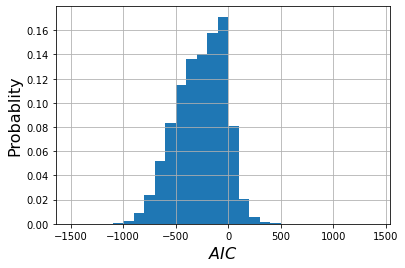

In [31]:
#notable death
fig=plt.figure()

death_lis=df_death_aic.loc["expbeki"].values.tolist()
death_weight=np.ones_like(death_lis)/len(death_lis)

plt.grid(True)

bins_lis=[]
for i in list(range(-15,15,1)):
    bins_lis.append(100*i)

plt.hist(death_lis,bins=bins_lis,weights=death_weight,alpha=1)
plt.xlabel("$AIC$",size=16)
plt.ylabel("Probablity",size=16)
#fig.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/figure_work/deathhistaic.eps")
plt.show()

### Parameter evaluation of exponent + power (alpha, beta)

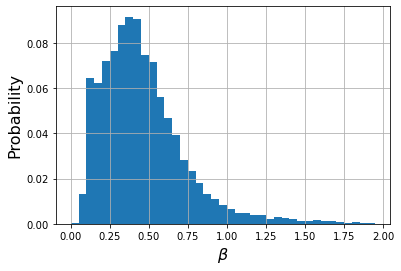

In [32]:
#β

bins_lis=[]
for i in list(range(0,40,1)):
    bins_lis.append(i/20)

death_lis=df_death_r.loc["expbeki_a"].values
death_weight=np.ones_like(death_lis)/len(death_lis)

fig=plt.figure()
plt.grid(True)
plt.hist(death_lis,bins=bins_lis,weights=death_weight,alpha=1)
plt.xlabel(r"$\beta$",size=16)
plt.ylabel("Probability",size=16)
#fig.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/figure_work/deathbeta.eps")
plt.show()

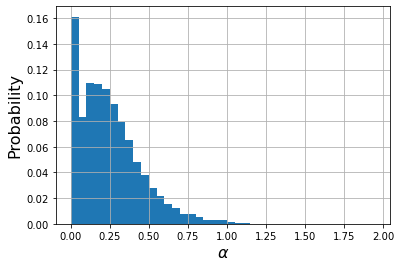

In [33]:
#α

bins_lis=[]
for i in list(range(0,40,1)):
    bins_lis.append(i/20)

death_lis=df_death_r.loc["expbeki_b"].values#αを抽出
death_weight=np.ones_like(death_lis)/len(death_lis)

fig=plt.figure()
plt.grid(True)
plt.hist(death_lis,bins=bins_lis,weights=death_weight,alpha=1)
plt.xlabel(r"$\alpha$",size=16)
plt.ylabel("Probability",size=16)
#fig.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/figure_work/deathalpha.eps")
plt.show()

In [34]:
#median
print("earthquake")
print(df_disaster_r.loc["expbeki_a"].median())
print(df_disaster_r.loc["expbeki_b"].median())

print("notable death")
print(df_death_r.loc["expbeki_a"].median())
print(df_death_r.loc["expbeki_b"].median())

print("aviation accident")
print(df_aviation_r.loc["expbeki_a"].median())
print(df_aviation_r.loc["expbeki_b"].median())

print("mass murder")
print(df_murder_r.loc["expbeki_a"].median())
print(df_murder_r.loc["expbeki_b"].median())

print("tero")
print(df_tero_r.loc["expbeki_a"].median())
print(df_tero_r.loc["expbeki_b"].median())

earthquake
0.3895057825563653
0.481453129221257
notable death
0.41770589262762536
0.21878174989293236
aviation accident
0.43436076026035264
0.3103395793776695
mass murder
0.4098506242956904
0.30262996586779795
tero
0.4323427633894709
0.32718607868800464


### Curve for each parameter (visual)

In [35]:
name_sample=[]
n_lis=[]
beta_lis=[0,0.25,0.5,0.75,1.0]
alpha_lis=[0,0.25,0.5,0.75]
alpha_lis.reverse()

for alpha in alpha_lis:
    for beta in beta_lis:

        #条件に当てはまるイベントを一つ取得
        name_lis_r=df_death_r.loc["expbeki"][(df_death_r.loc["expbeki_a"]>beta)
                                        &(df_death_r.loc["expbeki_a"]<beta+0.25) 
                                        &(df_death_r.loc["expbeki_b"]>alpha) 
                                        &(df_death_r.loc["expbeki_b"]<alpha+0.25) 
                                        &(df_death_r.loc["expbeki"]>0.90)
                                        ].index.tolist()
        
        name_lis=df_death_r.loc["expbeki"][(df_death_r.loc["expbeki_a"]>beta)
                                        &(df_death_r.loc["expbeki_a"]<beta+0.25) 
                                        &(df_death_r.loc["expbeki_b"]>alpha) 
                                        &(df_death_r.loc["expbeki_b"]<alpha+0.25) 
                                        ].index.tolist()
        
        if len([s for s in name_lis if "%" not in s])!=0:
            name=random.choice([s for s in name_lis if "%" not in s])
            name_sample.append(name)
        else:
            name=random.choice(name_lis)
            name_sample.append(name)
            
        n_lis.append(len(name_lis))

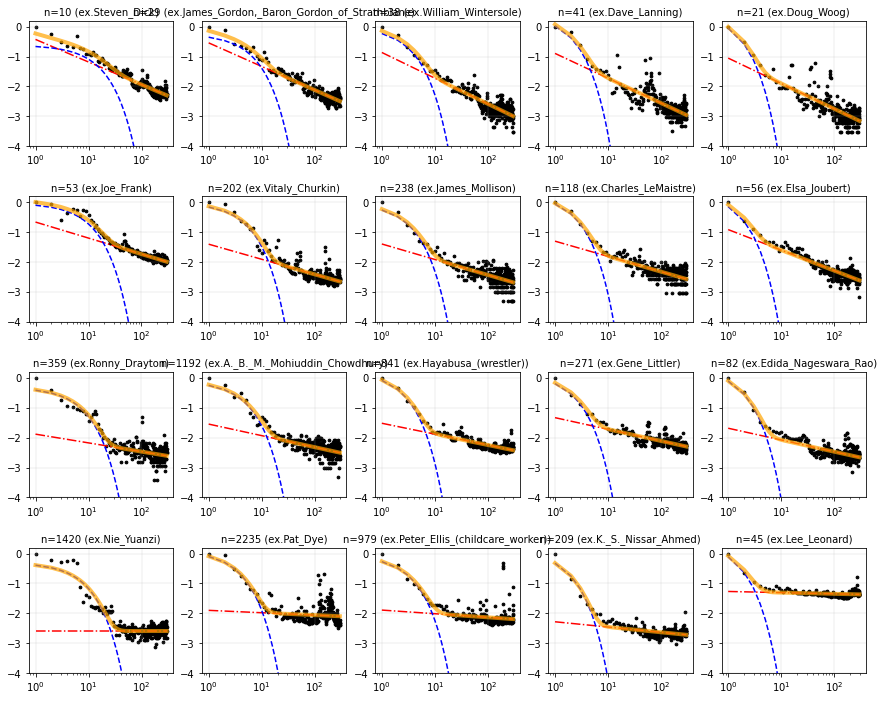

In [40]:
import matplotlib.pyplot as plt
import numpy as np
file="death"
df_decay=pd.read_csv(f"TimeSeries_pre/{file}_pre.csv", index_col=0)

fig = plt.figure(figsize=(15, 12))

rows_count=4 
columns_count=5 
graphs_count = rows_count * columns_count 
axes = [] 
x = np.linspace(1, 300, 300)

for i,name,n in zip(range(1, graphs_count+1),name_sample,n_lis):
    
    axes.append(fig.add_subplot(rows_count, columns_count, i))
    
    df_fromax=df_decay[name][df_decay[name].idxmax():]
    minimum = np.min(df_fromax.values[np.nonzero(df_fromax.values)])
    df=df_fromax+minimum
    df_norm=df/df.max()
    df_norm.reset_index(drop=True, inplace=True)

    y_analysis=np.log10(df_norm)
    x_analysis = np.linspace(1,len(y_analysis),len(y_analysis))#x

    popt_expbeki, _ = optimize.curve_fit(expbeki, x_analysis, y_analysis, bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))
    
    axes[i-1].scatter(x_analysis,y_analysis,marker='.',s=30, c="black")
    axes[i-1].plot(x_analysis,beki(x_analysis,popt_expbeki[2],popt_expbeki[3]),linestyle = "dashdot", label = "power-law", color = "red",alpha = 1)
    axes[i-1].plot(x_analysis,exp(x_analysis,popt_expbeki[0],popt_expbeki[1]),linestyle = "dashed", label = "Exponential", color = "blue",alpha = 1)
    axes[i-1].plot(x_analysis,expbeki(x_analysis,popt_expbeki[0],popt_expbeki[1],popt_expbeki[2],popt_expbeki[3]),linestyle = "solid", label = "proposed model", linewidth = 4, color = "orange",alpha = 0.7)

    axes[i-1].set_ylim(-4,0.2)
    axes[i-1].set_title(f'n={n} (ex.{name})', loc='center',size=10)
    axes[i-1].set_xscale("log")
    axes[i-1].grid(linewidth=0.2)

    fig.subplots_adjust(wspace=0.2, hspace=0.4) #グラフ間の隙間調整
    
plt.show()

### MemorySwitchingPoint

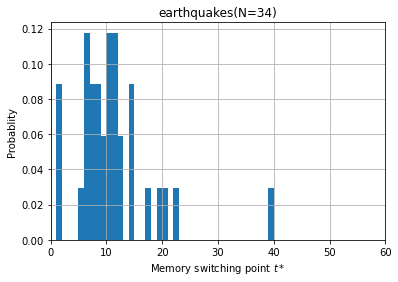

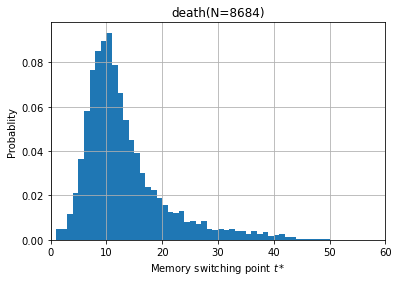

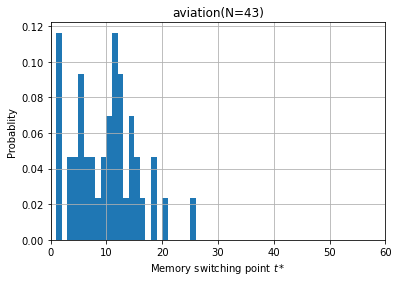

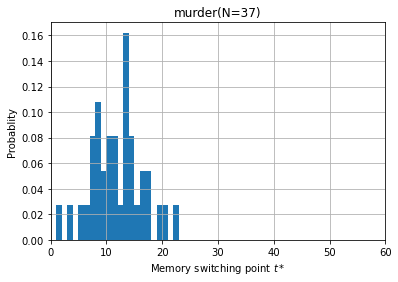

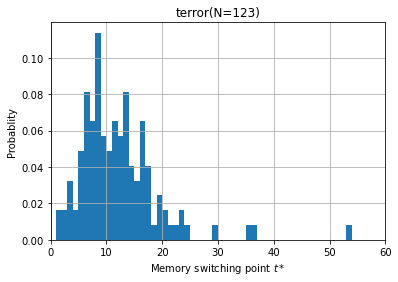

In [41]:
import statistics
import math
files=["disaster","death","aviation","murder","tero"]

for file in files:
    df=pd.read_csv(f"parameter/{file}_log.csv",index_col=0)
    lis=df.loc["switching_point"].values
    weight=np.ones_like(lis)/len(lis)
    
    fig=plt.figure()
    plt.grid(True)
    
    plt.grid(True)
    plt.xlim(0,60)
    bins_lis=list(range(1,61,1))
    
    plt.hist(lis,bins=bins_lis,weights=weight,alpha=1, histtype="stepfilled")
    plt.xlabel("Memory switching point $t*$",size=10)
    plt.ylabel("Probablity",size=10)
    
    if file=="disaster":
        plt.title(f"earthquakes(N={len(lis)})")
    elif file=="tero":
        plt.title(f"terror(N={len(lis)})")
    else:
        plt.title(f"{file}(N={len(lis)})")
    
    plt.show()
    #fig.savefig("")